In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, CuDNNLSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import time
import tensorflow as tf
tf.config.run_functions_eagerly(True)

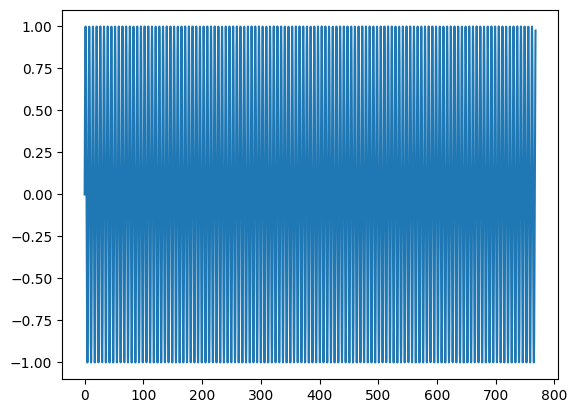

In [24]:
time = np.arange(0,768,0.1);
amplitute = np.sin(time)
plt.plot(time,amplitute)

In [25]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#reference: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [26]:
lag = 256
n_ahead = 128
train_share = 0.7
val_share = 0.8
epochs = 10
batch_size = 1

In [27]:
data = amplitute.reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(data)
ts_scaled = scaler.transform(data)

In [28]:
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [29]:
Xtrain, Ytrain = X[0:int(X.shape[0]* train_share)], Y[0:int(X.shape[0]*train_share)]
Xtest, Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0]*val_share):]
Xval, Yval = X[int(X.shape[0] * train_share):int(X.shape[0]*val_share)], Y[int(X.shape[0]*train_share):int(X.shape[0]*val_share)]

In [30]:
model = Sequential()

#model.add(LSTM(16, activation='tanh', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(CuDNNLSTM(16,input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
#model.add(LSTM(8, activation='tanh', return_sequences=False))
model.add(CuDNNLSTM(8,return_sequences=False))
model.add(Dense(128))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 256, 16)           1216      
                                                                 
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 8)                 832       
                                                                 
 dense_2 (Dense)             (None, 128)               1152      
                                                                 
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(Xtrain, Ytrain, epochs=epochs, validation_data=(Xval, Yval), shuffle=False, callbacks=[early_stopping])

Epoch 1/10
  1/160 [..............................] - ETA: 17s - loss: 0.5029 - mae: 0.5029

/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


160/160 [==============================] - 14s 88ms/step - loss: 0.3612 - mae: 0.3612 - val_loss: 0.3139 - val_mae: 0.3139
Epoch 2/10
160/160 [==============================] - 13s 81ms/step - loss: 0.2657 - mae: 0.2657 - val_loss: 0.1797 - val_mae: 0.1797
Epoch 3/10
 12/160 [=>............................] - ETA: 11s - loss: 0.1726 - mae: 0.1726

KeyboardInterrupt: 

In [ ]:
yhat = model.predict(Xtest)
yhat.shape

In [ ]:
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

pred_n_ahead = pd.DataFrame(scaler.inverse_transform(pred_n_ahead))
actual_n_ahead = pd.DataFrame(scaler.inverse_transform(actual_n_ahead))

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(pred_n_ahead, color='C0', marker='o', label='Predicted')
plt.plot(actual_n_ahead, color='C1', marker='o', label='Actual', alpha=0.6)
plt.title('Predicted vs Actual')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show

In [ ]:
def forecast_accuracy(forecast,actual):
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
  me = np.mean(forecast - actual)
  mae = np.mean(np.abs(forecast - actual))
  rmse = np.mean((forecast - actual)**2)**.5
  corr = np.corrcoef(forecast,actual)[0,1]
  return({'mape':mape, 'me':me, 'mae':mae, 'rmse':rmse, 'corr':corr})

forecast_accuracy(yhat,Ytest)